# STEM simulation from charge density

This notebook demonstrates how to simulate STEM images using a potential calculated from the all-electron density of a DFT calculation.

In [1]:
%matplotlib inline
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl
from ase.io import read
from pyqstem.util import atoms_plot
from pyqstem import PyQSTEM
from pyqstem.potentials import poisson_solver,create_potential_slices
mpl.rc('font',**{'size' : 13})

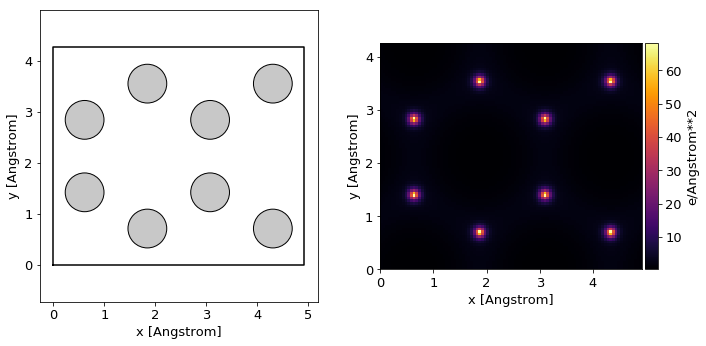

Total charge (in elementary charges): 47.9999438247


In [2]:
rho=np.load('graphene.npy') # all-electron density from GPAW using LDA
atoms=read('graphene.cif',index=0) # atomic configuration
cell=atoms.get_cell()

Lx,Ly,Lz=np.diag(atoms.get_cell())
Nx,Ny,Nz=rho.shape
res_x,res_y=Lx/Nx,Ly/Ny

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
atoms_plot(atoms,ax=ax1,scale_atoms=.5)
im=ax2.imshow(np.trapz(rho,dx=Lz/Nz,axis=2).T,extent=[0,Lx,0,Ly],cmap='inferno')
ax2.set_xlabel('x [Angstrom]')
ax2.set_ylabel('y [Angstrom]')
divider = make_axes_locatable(ax2)
cax2 = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im,cax=cax2,label='e/Angstrom**2')
plt.tight_layout()
plt.show()

print('Total charge (in elementary charges):',np.sum(rho*Lx*Ly*Lz/(Nx*Ny*Nz)))

We solve the Poisson equation for the all electron charge distribution and ions placed at the atomic positions. The solution is found using the spectral method(https://en.wikipedia.org/wiki/Spectral_method) and hence assumes periodic boundary conditions. The potential is repeated in order to accomodate the size of the probe at all scan positions over a rectangular cell.

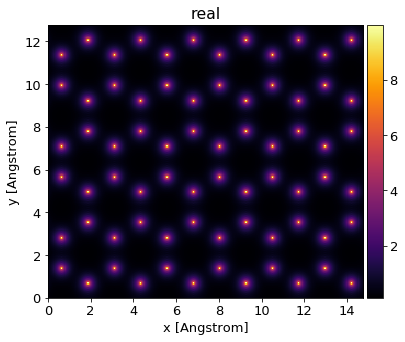

In [3]:
V=poisson_solver(rho,atoms,smooth=0,units='QSTEM')
V_dft=create_potential_slices(V,10,(Lx,Ly,Lz))
V_dft.array=np.tile(V_dft.array,(3,3,1))
tiled_atoms=atoms*(3,3,1)
V_dft.view(method='real',cmap='inferno')

In [4]:
qstem=PyQSTEM('STEM')
qstem.set_atoms(tiled_atoms)

A probe is created with the same resolution as the potential, but not the same number of samples.

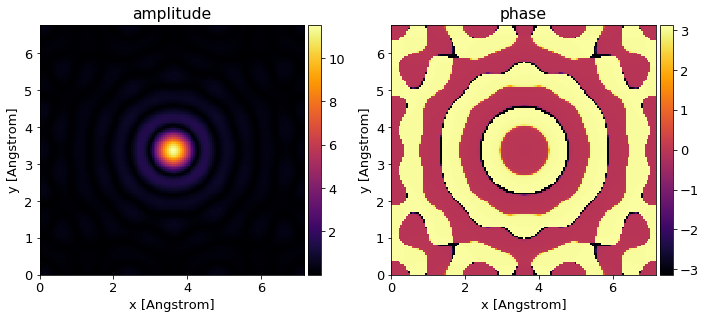

In [24]:
samples = (140,140) # samples in x and y-direction
resolution = (res_x,res_y) # the resolution shoudl match the potential
defocus = 1 # defocus [Angstrom]
v0 = 300 # acceleration voltage [keV]
alpha = 18 # convergence angle [mrad]
astigmatism = 0 # astigmatism magnitude [Angstrom]
astigmatism_angle = 20 # astigmatism angle [deg.]
aberrations = {'a33': 0, 'phi33': 30} # higher order aberrations [Angstrom] or [deg.]

qstem.build_probe(v0,alpha,samples,resolution=resolution,defocus=defocus,astig_mag=astigmatism,
                  astig_angle=astigmatism_angle,aberrations=aberrations)
wave=qstem.get_wave()

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,6))
wave.view(ax=ax1,method='amplitude',cmap='inferno')
wave.view(ax=ax2,method='phase',cmap='inferno')
plt.tight_layout()

We set a scan range over the central rectangular unit cell. The view method can be used to inspect the extent of the potential and the maximum extent of the probe array during a scan.

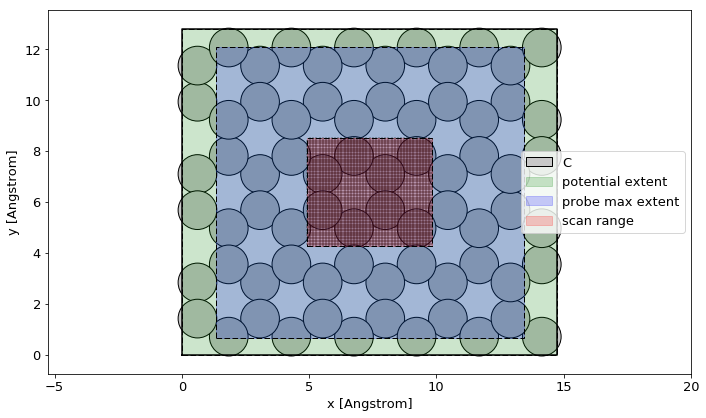

In [17]:
scan_range=[[cell[0,0],2*cell[0,0],40],
            [cell[1,1],2*cell[1,1],40]]
qstem.set_potential(V_dft,scan_range)

fig,ax=plt.subplots(1,1,figsize=(10,6))
qstem.view(ax=ax)
plt.show()

In [26]:
qstem.add_detector('det1',(70,200))
qstem.add_detector('det2',(0,70))
qstem.run()

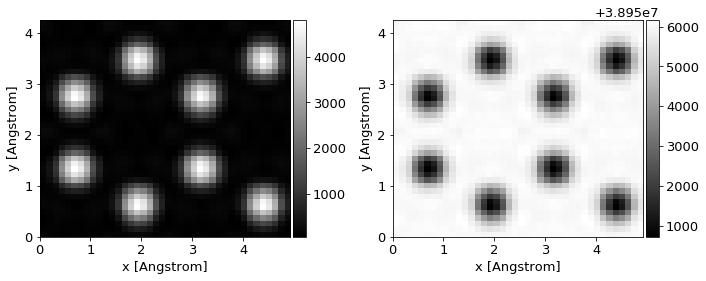

In [27]:
img1=qstem.read_detector('det1')
img2=qstem.read_detector('det2')

extent=[0,scan_range[0][1]-scan_range[0][0],0,scan_range[1][1]-scan_range[1][0]]

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,6))
ims1=ax1.imshow(img1.T,extent=extent,interpolation='nearest',cmap='gray')
divider = make_axes_locatable(ax1)
cax1 = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(ims1, cax=cax1)
ax1.set_xlabel('x [Angstrom]')
ax1.set_ylabel('y [Angstrom]')

ims2=ax2.imshow(img2.T,extent=extent,interpolation='nearest',cmap='gray')
divider = make_axes_locatable(ax2)
cax2 = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(ims2, cax=cax2)
ax2.set_xlabel('x [Angstrom]')
ax2.set_ylabel('y [Angstrom]')

plt.tight_layout()
plt.show()